Zachary Armand

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam, AdamW
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Linear, ReLU, Sequential

# Local import
from evaluate import train_model, evaluate_model, calculate_R2_score, get_predictions, best_hyperparameter_results, visualize_all_hyperparameter_results
from EarlyStopping import EarlyStopping

In [2]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [164]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

In [3]:
input_values = torch.load('./datasets/input_values.pth')
target_values = torch.load('./datasets/target_values.pth')

Dataset and dataloaders are used for both models.

In [4]:
# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataset, valid_dataset = random_split(train_dataset, [0.89, 0.11])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}, Valid: {len(valid_dataset)}")

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train: 80.1%, Test: 10.0%, Valid: 9.9%
Train: 57640, Test: 7195, Valid: 7123


In [5]:
# Convert datasets to tensors for easier manipulation
train_inputs = torch.stack([x[0] for x in train_dataset])
valid_inputs = torch.stack([x[0] for x in valid_dataset])
test_inputs = torch.stack([x[0] for x in test_dataset])

# Check the shape of the inputs to ensure it's 4D (e.g., (num_samples, channels, height, width))
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Valid inputs shape: {valid_inputs.shape}")
print(f"Test inputs shape: {test_inputs.shape}")

# Store the original shape for later reshaping
original_shape = train_inputs.shape[1:]  # (channels, height, width) or whatever your original shape was

# Reshape the inputs to 2D (samples, features) for scaling
train_inputs_reshaped = train_inputs.view(train_inputs.size(0), -1)
valid_inputs_reshaped = valid_inputs.view(valid_inputs.size(0), -1)
test_inputs_reshaped = test_inputs.view(test_inputs.size(0), -1)

# Scale the inputs using StandardScaler (you could also use MinMaxScaler or another scaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform
train_inputs_scaled = torch.tensor(scaler.fit_transform(train_inputs_reshaped.numpy()), dtype=torch.float32)

# Use the same scaler to transform the validation and test data
valid_inputs_scaled = torch.tensor(scaler.transform(valid_inputs_reshaped.numpy()), dtype=torch.float32)
test_inputs_scaled = torch.tensor(scaler.transform(test_inputs_reshaped.numpy()), dtype=torch.float32)

# Reshape the scaled inputs back to the original shape (samples, channels, height, width)
train_inputs_scaled = train_inputs_scaled.view(train_inputs.size(0), *original_shape)
valid_inputs_scaled = valid_inputs_scaled.view(valid_inputs.size(0), *original_shape)
test_inputs_scaled = test_inputs_scaled.view(test_inputs.size(0), *original_shape)

# Recreate the datasets with the scaled inputs
train_dataset = TensorDataset(train_inputs_scaled, torch.stack([x[1] for x in train_dataset]))
valid_dataset = TensorDataset(valid_inputs_scaled, torch.stack([x[1] for x in valid_dataset]))
test_dataset = TensorDataset(test_inputs_scaled, torch.stack([x[1] for x in test_dataset]))

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train inputs shape: torch.Size([57640, 9, 15])
Valid inputs shape: torch.Size([7123, 9, 15])
Test inputs shape: torch.Size([7195, 9, 15])


# Simple Linear model

### MLP hyperparameter tuning

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, in_features=12, seq_len=8, hidden_features=32, dropout=0.0):
        super().__init__()
        
        self.input_layer = nn.Linear(in_features*seq_len, hidden_features)
        self.middle_layer = nn.Linear(hidden_features, hidden_features)
        self.output_layer = nn.Linear(hidden_features, 1)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        # Input layer
        x = self.input_layer(x)
        x = self.relu(x)
        # Middle layer with residual
        x = self.middle_layer(x)
        x = self.relu(x)
        x = self.dropout(x)
        # Final output layer
        x = self.relu(self.output_layer(x))
        return x.squeeze()  # Remove extra dimension for regression tasks

In [48]:
# Number of random combinations to sample
num_random_combinations = 100  

# Define hyperparameters to test
testing_params = {
    'batch_size': [16, 64, 128, 256],
    'lr': [0.01, 0.001, 0.0001, 0.00001],
    'mlp_dropout': [0.0, 0.1, 0.25, 0.33, 0.5],
    'weight_decay': [0.0, 1e-2, 1e-3, 1e-4, 1e-5],
    'hidden_size': [8, 16, 64, 128, 256],
    'grad_clip': [None, 0.5, 1.0]
}

'''# Create a list of all parameter combinations
param_combinations = [(batch_size, lr, mlp_dropout, weight_decay, hidden_size)
                      for batch_size in testing_params['batch_size']
                      for lr in testing_params['lr']
                      for mlp_dropout in testing_params['mlp_dropout']
                      for weight_decay in testing_params['weight_decay']
                      for hidden_size in testing_params['hidden_size']
                      ]'''

# Generate random combinations
random_param_combinations = [
    (
        random.choice(testing_params['batch_size']),
        random.choice(testing_params['lr']),
        random.choice(testing_params['mlp_dropout']),
        random.choice(testing_params['weight_decay']),
        random.choice(testing_params['hidden_size']),
        random.choice(testing_params['grad_clip'])
    )
    for _ in range(num_random_combinations)
]

# Save what parameters are being tested
mlp_hyperparam_testing = pd.DataFrame(random_param_combinations, columns=testing_params.keys())

In [ ]:
results = {}
num_epochs = 100
early_stop_patience = 15
loss = 'MSE'

# Initialize tqdm progress bar to track progress through iterations
pbar = tqdm(random_param_combinations, desc="Training Models", total=len(random_param_combinations))

# Iterate over parameter combinations
for i, (batch_size, lr, mlp_dropout, weight_decay, hidden_size, grad_clip) in enumerate(pbar):

    # Turn dataset into Dataloaders
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # Create model
    in_features, seq_len = valid_dataloader.dataset[0][0].shape
    simple_baseball_mlp = SimpleNet(in_features=in_features, seq_len=seq_len, hidden_features=hidden_size, dropout=mlp_dropout).to(DEVICE)

    # Optimizer and early stopper
    optimizer = Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

    # Training
    eval_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Validation loss
        avg_valid_loss = train_model(simple_baseball_mlp, optimizer, valid_dataloader, DEVICE, loss_fn=loss, grad_clip=grad_clip)
        eval_log.append(avg_valid_loss)
    
        # Early Stopping
        early_stopper(avg_valid_loss)
        if early_stopper.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break    
    
    # Save results
    results[i] = [eval_log]

    # Test evaluation
    test_accuracy = evaluate_model(model=simple_baseball_mlp, data_loader=test_dataloader, device=DEVICE, loss_fn=loss)
    # Save results
    results[i].append(test_accuracy)
    results[i].append(f'Batch size: {batch_size}, lr: {lr}, dropout: {mlp_dropout}\n l2: {weight_decay}, hidden_size: {hidden_size}, grad_clip: {grad_clip}\{loss}: {test_accuracy:.4}')
    # Append training epochs
    results[i].append(epoch+1)


Training Models: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


Evaluate the models, first by lowest RSME. Also visualize results to make sure that they aren't overfitting.

6 best models (index and values):
(33, 0.1395517642792933)
(9, 0.13967890168661207)
(8, 0.1399457362861663)
(35, 0.13996309049950448)
(58, 0.1399764295996188)
(30, 0.14016198027125656)


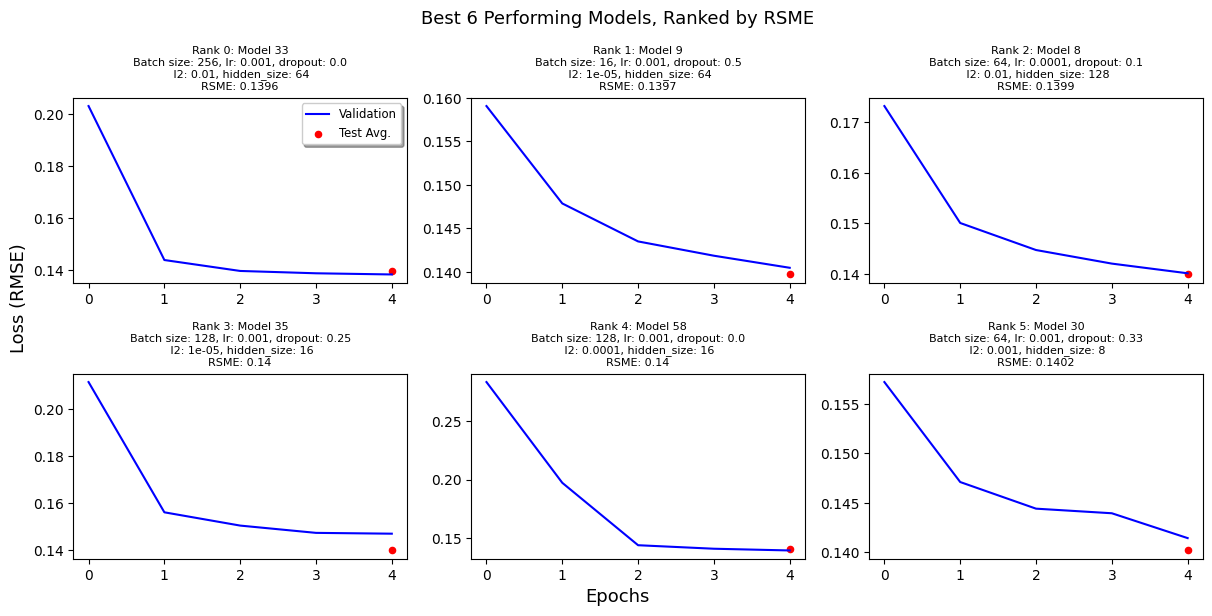

In [ ]:
best_hyperparameter_results(results, loss=loss, n_best=6)

In [ ]:
#visualize_all_hyperparameter_results(results, loss=loss)

A little bit of fine-tuning. Mostly just training to decide the optimal batch size. Take the top performing metrics, and then tune these hyperparameters, but this time with more training epochs. From this, choose the best hyperparameters to use in the final model. 

In [174]:
#print(f"Batch size 32 validation loss variance: {np.var(np.array(results_mlp[0][1])):.6f}")
#print(f"Batch size 64 validation loss variance: {np.var(np.array(results_mlp[1][1])):.6f}")

In [52]:
# Save full results to csv
mlp_hyperparam_testing['tuning_epochs'] = [results[i][3] for i in results]
mlp_hyperparam_testing[f'tuning_loss_{loss}'] = [results[i][1] for i in results]
mlp_hyperparam_testing.to_csv('./tuning/mlp_hyperparameter_tuning.csv')

### MLP Final Results

After hyperparameter tuning, the linear network hyperparameters are:
- Batch size: 64
- Learning rate: 0.001
- Dropout: 0.0
- L2 weight decay: 0.0

Batch size of 64, while slightly higher RSME than 32, appeared to have a more stable training. The variation of the loss is lower, and the plot of the validatoin set has fewer spikes.
This is somewhat interesting, as the models with some regularization (dropout, weight decay) performed less well than the models with none. 

# RNN Network

A many-to-one RNN using gated recurrence units (GRUs)

In [175]:
class BaseballRNN(torch.nn.Module):
    def __init__(self, input_size, output_size=1, hidden_size=256, n_layers=1, bidirectional=False, hidden_init='rand', rnn_dropout=0.2):
        super().__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.hidden_init = hidden_init
        self.rnn_dropout = rnn_dropout

        self.rmsnorm = nn.modules.normalization.RMSNorm(input_size)


        # Input fc layer
        self.fc_in = nn.Linear(input_size, self.hidden_size)
        # GRU Layer
        self.rnn1 = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True, num_layers=self.n_layers, dropout=self.rnn_dropout, bidirectional=False)
        # Dropout layer after last GRU layer
        self.layernorm = nn.LayerNorm(self.hidden_size)
        self.dropout = nn.Dropout(self.rnn_dropout)
        # Fully connected layer
        self.fc1 = nn.Linear(self.hidden_size, 32)  # fixed number of neurons in the linear layer
        # Output layer
        self.fc_out = nn.Linear(32, output_size) 
        
        # RELU
        self.relu = nn.ReLU()

    def _init_hidden(self, batch_size, device):
        """Initialize the hidden state for the GRU."""
        if self.hidden_init == 'zero':
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        elif self.hidden_init == 'rand':
            h0 = torch.randn(self.n_layers, batch_size, self.hidden_size, device=device)
        elif self.hidden_init == 'xavier':
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
            nn.init.xavier_uniform_(h0)
        else:
            raise ValueError(f"Unsupported hidden_init: {self.hidden_init}")
        return h0

    def forward(self, x):      
        # Initial hidden states for RNNs
        h0 = self._init_hidden(x.size(0), x.device)

        
        x = self.rmsnorm(x)
        # Pre RNN Linear Layer
        x = self.relu(self.fc_in(x))

        # Send through RNN 
        #residual = x
        out, hidden = self.rnn1(x, h0)
        #out = out + residual  # Residual connection
        # Get output of the last time step
        out = out[:, -1, :]  # (batch_size, seq_len, hidden_size)
        out = self.layernorm(out)
        out = self.dropout(out)

        # Send through fully connected layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out) #+ out

        # Output layer
        out = self.fc_out(out)

        return out.squeeze()

In [ ]:
# Number of random combinations to sample
num_random_combinations = 50  

# Define hyperparameters to test
testing_params = {
    'batch_size': [32, 64, 128, 256],
    'n_layers': [1, 2, 3],
    'lr': [0.01, 0.001, 0.0001, 0.00001],
    'rnn_dropout': [0.0, 0.1, 0.2, 0.33, 0.5],
    'weight_decay': [0.0, 1e-2, 1e-3, 1e-4, 1e-5],
    'grad_clip': [None, 0.5, 1.0]
}

'''# Create a list of all parameter combinations
param_combinations = [(batch_size, n_layers, lr, rnn_dropout, weight_decay, grad_clip)
                      for batch_size in testing_params['batch_size']
                      for n_layers in testing_params['n_layers']
                      for lr in testing_params['lr']
                      for rnn_dropout in testing_params['rnn_dropout']
                      for weight_decay in testing_params['weight_decay']
                      for grad_clip in testing_params['grad_clip']
                      ]'''

# Generate random combinations
random_param_combinations = [
    (
        random.choice(testing_params['batch_size']),
        random.choice(testing_params['n_layers']),
        random.choice(testing_params['lr']),
        random.choice(testing_params['rnn_dropout']),
        random.choice(testing_params['weight_decay']),
        random.choice(testing_params['grad_clip'])
    )
    for _ in range(num_random_combinations)
]

# Save what parameters are being tested
rnn_hyperparam_testing = pd.DataFrame(random_param_combinations, columns=testing_params.keys())

In [ ]:
results_rnn = {}
num_epochs = 100
early_stop_patience = 15
loss = 'MSE'

# Initialize tqdm progress bar to track progress through 144 iterations
pbar = tqdm(random_param_combinations, desc="Training Models", total=len(random_param_combinations))

# Iterate over parameter combinations
for i, (batch_size, n_layers, lr, rnn_dropout, weight_decay, grad_clip) in enumerate(pbar):

    # Turn into Dataloaders
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # Create model
    input_size = valid_dataloader.dataset[0][0].size()[1]
    baseball_rnn = BaseballRNN(input_size=input_size, output_size=1, hidden_size=36,
                                    n_layers=n_layers, hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

    # Optimizer and early stopping
    optimizer = Adam(baseball_rnn.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

    # Training
    eval_log_rnn = []
    for epoch in range(num_epochs):
        
        # Validation loss
        avg_valid_loss = train_model(baseball_rnn, optimizer, valid_dataloader, DEVICE, loss_fn=loss, grad_clip=grad_clip)
        eval_log_rnn.append(avg_valid_loss)
        # Early Stopping
        early_stopper(avg_valid_loss)
        if early_stopper.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break    

    # Save results
    results_rnn[i] = [eval_log_rnn] 

    # Test evaluation
    test_accuracy_rnn = evaluate_model(model=baseball_rnn, data_loader=test_dataloader, device=DEVICE, loss_fn=loss)
    # Save results
    results_rnn[i].append(test_accuracy_rnn)
    results_rnn[i].append(f'Batch size:{batch_size}, lr:{lr}, n_layers:{n_layers}, dropout:{mlp_dropout}\n l2:{weight_decay}, hidden_size:{hidden_size}, grad_clip:{grad_clip}\n{loss}: {test_accuracy_rnn:.4}')

    # Append training epochs
    results_rnn[i].append(epoch+1)


Training Models:  16%|█▌        | 8/50 [09:37<36:25, 52.04s/it]   c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Training Models:  30%|███       | 15/50 [20:49<43:09, 73.99s/it]   c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
Training Models:  32%|███▏      | 16/50 [23:36<57:52, 102.13s/it]c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gr

In [ ]:
best_hyperparameter_results(results_rnn, loss=loss, n_best=6)

NameError: name 'results_rnn' is not defined

In [ ]:
#visualize_all_hyperparameter_results(results_rnn, loss=loss)

In [ ]:
# Save full results to csv
rnn_hyperparam_testing['tuning_epochs'] = [results_rnn[i][3] for i in results_rnn]
rnn_hyperparam_testing[f'tuning_loss_{loss}'] = [results_rnn[i][1] for i in results_rnn]
rnn_hyperparam_testing.to_csv('./tuning/rnn_hyperparameter_tuning.csv')

NameError: name 'results_rnn' is not defined

Showing effect of dropout on final model performance

In [181]:
# Initialize the model and move it to the appropriate device
dropout_tests = [0.0, 0.2, 0.3, 0.4, 0.5]
dropout_losses = {dp: [[], []] for dp in dropout_tests}

num_epochs = 100

for rnn_dropout in dropout_tests:

    # Initialize model
    input_size = test_dataloader.dataset[0][0].size()[1]
    RNN_model = BaseballRNN(input_size=input_size, output_size=1, hidden_size=128, 
                                 n_layers=2, hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(RNN_model.parameters(), lr=0.001)

    # Training loop
    log = []
    eval_log = []

    # Training loop
    pbar = tqdm(range(num_epochs), desc=f"Training RNN ({rnn_dropout})")
    for epoch in pbar:

        # Get average loss over batches for training
        avg_train_loss = train_model(RNN_model, optimizer, test_dataloader, DEVICE, loss_fn='RMSE')
        #log.append(avg_train_loss)
        avg_valid_loss = evaluate_model(RNN_model, valid_dataloader, DEVICE, loss_fn='RMSE')
        #eval_log.append(avg_valid_loss)
        dropout_losses[rnn_dropout][0].append(avg_train_loss)
        dropout_losses[rnn_dropout][1].append(avg_valid_loss)

        pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})


Training RNN (0.5): 100%|██████████| 100/100 [01:05<00:00,  1.53it/s, Train loss=0.259, Validation loss=0.419]


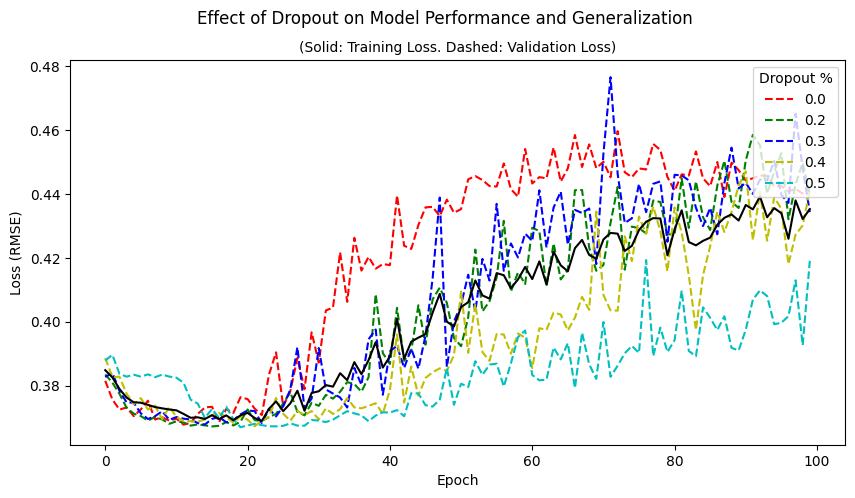

In [182]:
# Plot loss over time
plt.figure(figsize=(10, 5))
plt.suptitle(f'Effect of Dropout on Model Performance and Generalization', fontsize=12)
plt.title(f'(Solid: Training Loss. Dashed: Validation Loss)', fontsize=10)
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
colors = ['r', 'g', 'b', 'y', 'c']
for i, dp in enumerate(dropout_tests):
    #plt.plot(dropout_losses[dp][0], label=dp, linestyle='solid')
    plt.plot(dropout_losses[dp][1], linestyle='dashed', c=colors[i], label=dp)
plt.plot(np.array([dropout_losses[dl][1] for dl in dropout_losses]).mean(axis=0), color='black')
plt.legend(title='Dropout %', loc='upper right')

plt.show()